In [32]:
%reload_ext autoreload
%autoreload 2
from spice_net import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import PySpice
from helpers import *

In [33]:
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-subprocess'

## Prelim

### Helpers

In [3]:
def train(net: LinearNetwork, xs, ys, epochs, gamma = 0.01, eta = 0.1, shuffle=True):
    n_nodes = len(net.__nodes__)
    n_edges = len(net.edges)

    loss = np.empty(epochs+1)
    weights = np.empty((epochs+1, xs.shape[0], n_edges))
    updates = np.empty((epochs, xs.shape[0], n_edges))

    # Calculate initial accuracy 
    pred = np.array([net.predict(x) for x in xs])
    loss[0] = np.sum((ys - pred)**2)
    weights[0] = np.tile([R.resistance for R in net.edges], (xs.shape[0],1))

    for i in range(epochs):
        if shuffle:
            perm = np.random.permutation(len(xs))
            xs = xs[perm]
            ys = ys[perm]
        for j, x, y in zip(range(xs.shape[0]), xs, ys):
            free = net.solve(x)
            nudges = eta * y + (1-eta) * net.predict(x)
            clamped = net.solve(x, nudges)

            free_rep = np.tile(free, [n_nodes, 1])
            clamped_rep = np.tile(clamped, [n_nodes,1])

            delta_free = free_rep - free_rep.T
            delta_clamped = clamped_rep - clamped_rep.T

            update = -gamma * (delta_clamped**2 - delta_free**2)
            trainable_updates = np.empty(n_edges)
            for k, R in enumerate(net.edges):
                a, b = list(map(int, R.node_names))
                trainable_updates[k] = update[a, b] #/ (R.resistance**2)

            net.update_y(trainable_updates)
            updates[i, j] = trainable_updates
            weights[i+1, j] = [R.resistance for R in net.edges]

        pred = np.array([net.predict(x) for x in xs])
        loss[i+1] = np.mean((ys - pred)**2)
        print(f'Epoch {i+1}: {loss[i+1]}')

    return net, loss, updates, weights
    
def visualize(net: LinearNetwork):
    G = nx.DiGraph()
    colors = []
    sources = []
    edges = []
    G.add_nodes_from(net.__nodes__)

    for R in net.edges:
        a, b = list(map(int, R.node_names))
        G.add_edge(a, b, weight=R.resistance, type='edge')
        G.add_edge(b, a, weight=R.resistance, type='edge')

    for V in net.inputs:
        a, b = list(map(int, V.node_names))
        G.add_edge(b, a, weight=V.dc_value, type='source', io='input')

    for V in net.outputs:
        a, b = list(map(int, V.node_names))
        G.add_edge(b, a, weight=V.dc_value, type='source', io='output')
        
    def filter_type(label):
        return lambda u, v: G.get_edge_data(u, v, default={'type':None})['type'] == label

    inputs_only = nx.subgraph_view(G, filter_edge=lambda u, v: filter_type('source')(u, v) and G.get_edge_data(u, v, default={'type':None})['io'] == 'input')
    outputs_only = nx.subgraph_view(G, filter_edge=lambda u, v: filter_type('source')(u, v) and G.get_edge_data(u, v, default={'type':None})['io'] == 'output')
    edges_only = nx.subgraph_view(G, filter_edge=filter_type('edge')).to_undirected(as_view=True)

    pos = nx.circular_layout(G)

    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(edges_only, pos, edge_color='black',)
    nx.draw_networkx_edge_labels(edges_only, pos, edge_labels={(u, v): round(edges_only[u][v]['weight'], 2) for u, v in edges_only.edges()})
    nx.draw_networkx_edges(inputs_only, pos, edge_color='red', connectionstyle='arc3,rad=0.2')
    nx.draw_networkx_edges(outputs_only, pos, edge_color='purple', connectionstyle='arc3,rad=0.2')
    # nx.draw_networkx_edge_labels(sources_only, pos, edge_labels={(u, v): sources_only[u][v]['io'] for u, v in sources_only.edges()},)


### Training a Toy Voltage Divider

In [195]:
vd_graph = nx.from_numpy_array(np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]))
vd_graph[1][0]['weight'] = -1
vd_graph[2][1]['weight'] = -2
vd = LinearNetwork('voltage_divider', con_graph=vd_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)
# visualize(vd)

In [197]:
import numpy as np

In [202]:
np.fft.ifft(np.fft.fft([1, 2,3, 4]))

array([1.+0.j, 2.+0.j, 3.+0.j, 4.+0.j])

In [196]:
vd.predict(dset['x']), dset['y']

(array([[ 6.67851256e-29],
        [ 1.11111111e-01],
        [ 2.22222029e-01],
        [ 3.32247719e-01],
        [-1.52259339e-01],
        [-4.98302275e-01]]),
 array([[0.        ],
        [0.22222222],
        [0.44444444],
        [0.66666667],
        [0.44444444],
        [0.22222222]]))

In [155]:
visualize(vd)

ValueError: too many values to unpack (expected 2)

In [156]:
print(vd)

.title voltage_divider
.subckt e1 t_D t_S
V1 t_G t_S 5
R1 t_D dummy 0.0001
M1 dummy t_G t_S t_S Ideal
.model Ideal NMOS (level=1)
.ends e1

.subckt e2 t_D t_S
V1 t_G t_S 5
R1 t_D dummy 0.0001
M1 dummy t_G t_S t_S Ideal
.model Ideal NMOS (level=1)
.ends e2
B1 2 0
B2 1 0
Vindex index 0 1
R1 0 1 5
R2 1 2 5
Rdummy1 1 0 1e+16
Rdummy2 2 0 1e+16
X1 0 1 e1
X2 1 2 e2



In [157]:
dset = {}
dset['x'] = np.array([0, 1, 2, 3, 2, 1])[:,None]/3
dset['y'] = dset['x'] * 2 / 3

In [167]:
vd, loss, updates, weights = train(vd, dset['x'], dset['y'], 20, gamma=10)

Epoch 1: 0.009766461971018827
Epoch 2: 0.009764300798731538
Epoch 3: 0.009762947052369244
Epoch 4: 0.009759962704566529
Epoch 5: 0.009757776270050061
Epoch 6: 0.009755611021298695
Epoch 7: 0.009753474154542469
Epoch 8: 0.009751263179745971
Epoch 9: 0.009749152179121602
Epoch 10: 0.00974695685693128
Epoch 11: 0.009744790222555514
Epoch 12: 0.009744596086351788
Epoch 13: 0.009743302164144223
Epoch 14: 0.009740634676060714
Epoch 15: 0.00974079145999901
Epoch 16: 0.009741252994604347
Epoch 17: 0.00973940359384888
Epoch 18: 0.009736061563581202
Epoch 19: 0.009734541266226002
Epoch 20: 0.009733623272935076


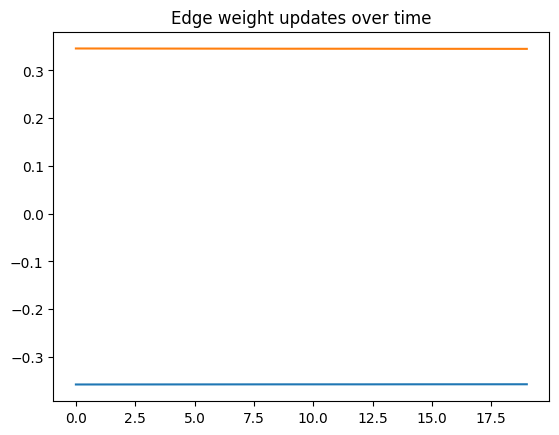

In [168]:
plt.plot(updates.sum(axis=1))
plt.title('Edge weight updates over time')
plt.show()

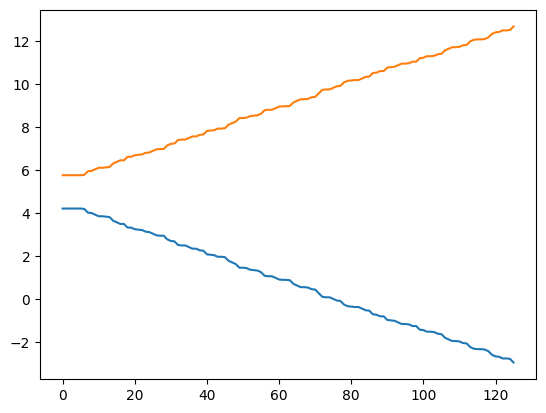

In [169]:
plt.plot(weights.reshape(-1, weights.shape[-1]))
plt.show()

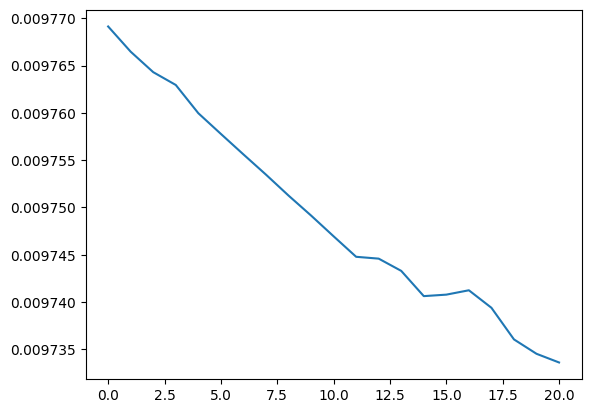

In [170]:
plt.plot(loss)
plt.show()

In [171]:
[vd.predict(i) for i in dset['x']], dset['y']

([array([[-3.13767736e-29]]),
  array([[0.16677286]]),
  array([[0.33361873]]),
  array([[0.50032901]]),
  array([[0.33361873]]),
  array([[0.16677286]])],
 array([[0.        ],
        [0.22222222],
        [0.44444444],
        [0.66666667],
        [0.44444444],
        [0.22222222]]))

In [60]:
print(vd)

.title voltage_divider
.subckt e1 t_D t_S
V1 t_G 0 -0.5569498260321502
R1 t_D dummy 0.0001
M1 dummy t_G t_S t_S Ideal
.model Ideal NMOS (level=1)
.ends e1

.subckt e2 t_D t_S
V1 t_G 0 2.609725119910192
R1 t_D dummy 0.0001
M1 dummy t_G t_S t_S Ideal
.model Ideal NMOS (level=1)
.ends e2
B1 2 0 v=1
Vindex index 0 1
R1 0 1 1
R2 1 2 1
Rdummy1 1 0 1e+16
Rdummy2 2 0 1e+16
X1 0 1 e1
X2 1 2 e2



### Looking at inputs, outputs, and updates on toy dataset

In [529]:
eta = 0.1
for i in range(len(dset['x'])):
    free = vd.solve(dset['x'][i])
    nudges = eta * (dset['y'][i]) + (1-eta)*vd.predict(dset['x'][i])
    clamped = vd.solve(dset['x'][i], nudges)
    n = clamped.shape[0]
    free_rep = np.tile(free, [n, 1])
    clamped_rep = np.tile(clamped, [n,1])

    delta_free = free_rep - free_rep.T
    delta_clamped = clamped_rep - clamped_rep.T

    update = -10 * (delta_clamped**2 - delta_free**2) 

    trainable_updates = np.empty(len(vd.edges))
    for k, R in enumerate(vd.edges):
        a, b = list(map(int, R.node_names))
        trainable_updates[k] = update[a, b] 

    print(free, clamped, trainable_updates)

[0 0 0] [0 0 0] [0. 0.]
[0.         0.33355507 1.        ] [0.        0.3335329 1.       ] [ 0.00014791 -0.00029555]
[0.         0.66711015 2.        ] [0.        0.6670658 2.       ] [ 0.00059165 -0.00118218]
[0.         1.00066519 3.        ] [0.         1.00059867 3.        ] [ 0.00133122 -0.00265991]
[0.         0.66711015 2.        ] [0.        0.6670658 2.       ] [ 0.00059165 -0.00118218]
[0.         0.33355507 1.        ] [0.        0.3335329 1.       ] [ 0.00014791 -0.00029555]


In [530]:
print(vd)
vd.update_y(trainable_updates)
print(vd)

.title voltage_divider
V1 2 0 1
V2 1 0 0.33353289862473806
R1 0 1 0.7853147710952183
R2 1 2 1.5690634503577705

.title voltage_divider
V1 2 0 1
V2 1 0 0.33353289862473806
R1 0 1 0.7852235609299365
R2 1 2 1.5697914094673382



In [531]:
clamped, free

(array([0.       , 0.3335329, 1.       ]),
 array([0.        , 0.33355507, 1.        ]))

In [532]:
update

array([[-0.        ,  0.00014791, -0.        ],
       [ 0.00014791, -0.        , -0.00029555],
       [-0.        , -0.00029555, -0.        ]])

In [533]:
delta_clamped**2, delta_free**2

(array([[0.       , 0.1112442, 1.       ],
        [0.1112442, 0.       , 0.4441784],
        [1.       , 0.4441784, 0.       ]]),
 array([[0.        , 0.11125899, 1.        ],
        [0.11125899, 0.        , 0.44414884],
        [1.        , 0.44414884, 0.        ]]))

In [534]:
[(i, vd.predict(i)) for i in dset['x']]

[(array([0]), array([0.])),
 (array([1]), array([0.33342615])),
 (array([2]), array([0.6668523])),
 (array([3]), array([1.00027847])),
 (array([2]), array([0.6668523])),
 (array([1]), array([0.33342615]))]

In [535]:
print(vd)

.title voltage_divider
V1 2 0 1
R1 0 1 0.7852235609299365
R2 1 2 1.5697914094673382



## Linear Regression

#### Generate the dataset

In [159]:
# Generate N random points
N = 32
split = 0.8
pts = np.random.rand(N) 
sigma = 0.001

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate categories with nonlinear decision boundary
m = np.random.random() 
b = np.random.random()

model = (lambda m, b: lambda x: m*x + b)(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

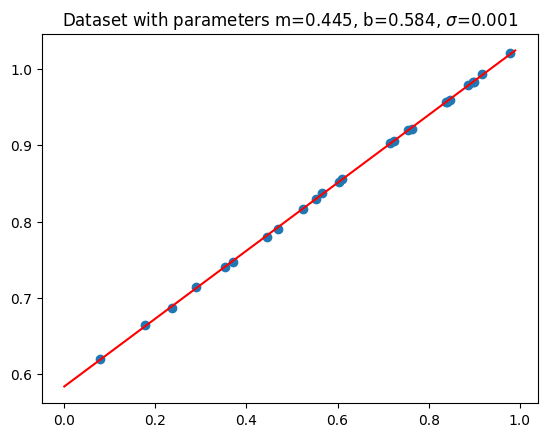

In [160]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
xs = np.arange(0, 1, 0.01)
plt.plot(xs, model(xs), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

#### Generate random linear network

In [189]:
# Parameters
nodes = 6
edge_prob = 1.0
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob)
for u, v in con_graph.edges():
    # con_graph[u][v]['weight'] = 1. 
    con_graph[u][v]['weight'] = 1./np.random.rand()

print('Num edges:', con_graph.number_of_edges())

in_nodes = 2
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 15


(array([[1, 3],
        [0, 2]]),
 array([[4, 5]]))

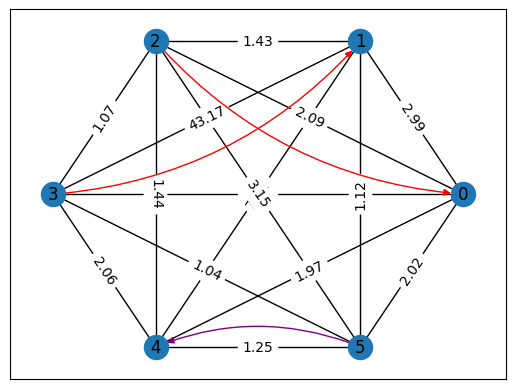

In [190]:
lin = LinearNetwork('fully_connected', con_graph, node_cfg)
visualize(lin)

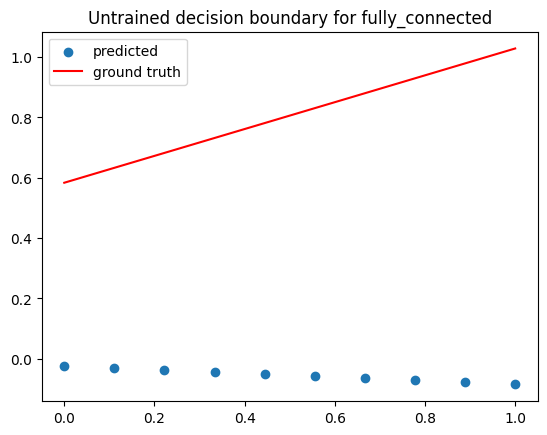

In [191]:
test_net = lin
lh = 1
num_pts = 10
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict([x, 1]) for x in np.linspace(0, lh, num_pts)]
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train both networks

In [192]:
augmented = np.hstack((training['x'], np.ones(training['x'].shape)))

In [201]:
# Train linear network
epochs = 10
trained_lin, loss, updates, weights = train(lin, augmented, training['y'], epochs, gamma=10, eta=0.1, shuffle=False)

Epoch 1: 0.004337551786440739
Epoch 2: 0.0012973111892268143
Epoch 3: 0.003406023999941937
Epoch 4: 0.0004373236117096117
Epoch 5: 0.0019741464615236084
Epoch 6: 0.00011696294086526947
Epoch 7: 0.001002370006085665
Epoch 8: 1.499522168981566e-05
Epoch 9: 0.0005443564697637258
Epoch 10: 1.165111107290781e-05


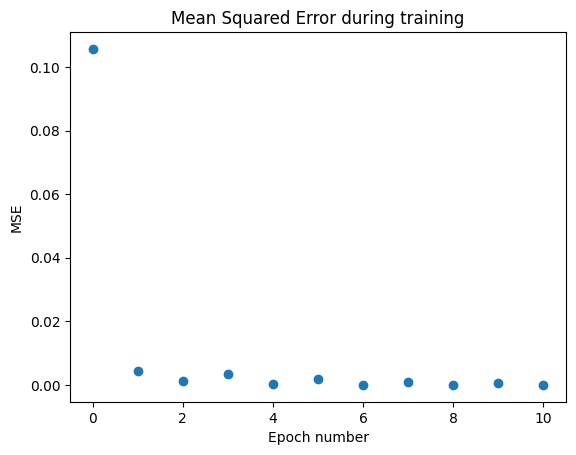

In [202]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

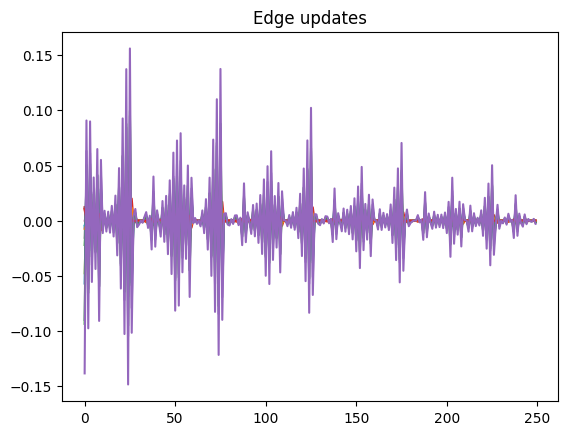

In [203]:
plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1])[:,1./weights[-1,-1,:] > 1e-5], -5, 5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

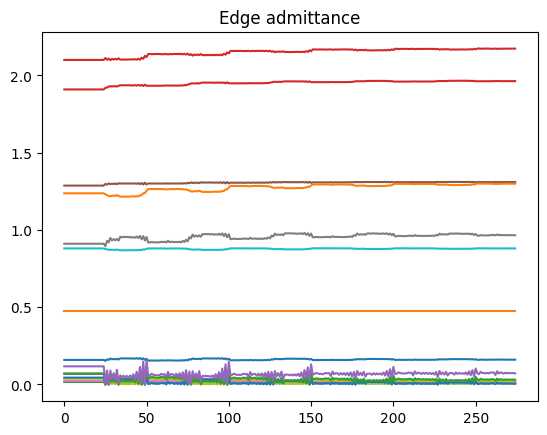

In [204]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

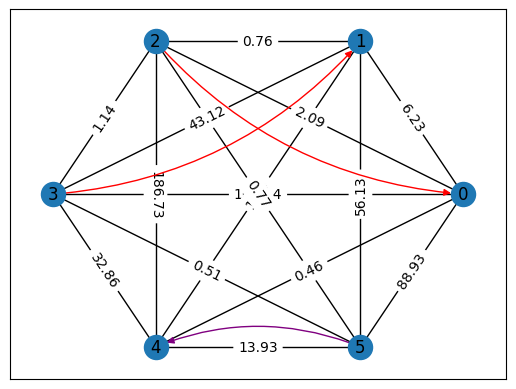

In [205]:
visualize(trained_lin)

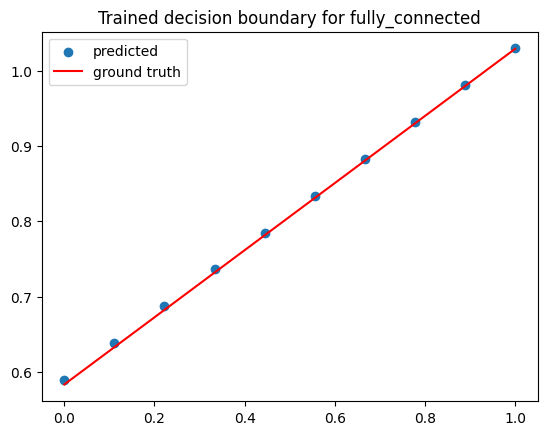

In [206]:
test_net = lin
lh = 1
num_pts = 10
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict([x,1]) for x in np.linspace(0, lh, num_pts)]
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()

### Visualize training results over time

In [199]:
for test_it in range(epochs+1):
    tm = np.zeros((len(lin.__nodes__), len(lin.__nodes__)))
    for i, R in enumerate(lin.edges):
        a, b = list(map(int, R.node_names))
        tm[a, b] = weights[test_it,0][i]
        tm[b, a] = weights[test_it,0][i]
    test_net = LinearNetwork(f'{lin.name}_{test_it}', con_mat = tm, node_cfg=node_cfg)
    lh = 1
    num_pts = 10
    xs = np.linspace(0, lh, num_pts)
    ys = [test_net.predict([x,1]) for x in np.linspace(0, lh, num_pts)]

    # plt.scatter(xs, ys)
    # plt.plot(xs, model(xs), 'r')
    # plt.title(f'Decision boundary for {test_net.name}')
    # plt.legend(['predicted', 'ground truth'])
    # plt.show()
    visualize(test_net)
    plt.show()
    loss[test_it]

TypeError: LinearNetwork.__init__() got an unexpected keyword argument 'con_mat'